# invert synthetic data using different parameterizations

In [1]:
import sys, glob, os
from srfpython import *
try:
    check_herrmann_codes()
except Exception:
    recompile_src90(yes=False)
    check_herrmann_codes()

In [2]:
%run -i ../../srfpython/bin/HerrMet -h

HerrMet V5.0
# ----------------------------------------------------
-w           i       set the number of virtual workers to use for all parallelized processes, default 4
-taskset     s       change job affinity for all parallelized processes, default 0-3
-agg                 use agg backend (no display) if mentioned
-lowprio             run processes with low priority if mentioned
-inline              replace showme by plt.show (e.g. jupyter)
-verbose off         reduce verbosity
-cmap                colormap, default gray
# ----------------------------------------------------
--version, -v        display version and quit
--help, -h           display this help message, and quit
--example, -ex       display an example of script, and quit
--param      i f     generate a template parameter file to custom, need the number of layers 
                     and bottom depth in km
    -basedon s       build parametrization based on an existing mod96 file, require a filename, 
                

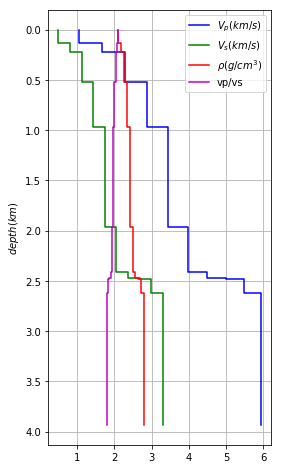

In [3]:
# -----------------
# generate a random depth model
# -----------------
ztop = np.unique(np.sort(np.random.rand(10))) * 3.
ztop[0] = 0.
vs   = np.linspace(.5, 3.3, len(ztop))
pr   = np.linspace(2.1, 1.8, len(ztop))
rh   = np.linspace(2.1, 2.8, len(ztop))
vp = np.array(pr) * np.array(vs)

dm = depthmodel_from_arrays(ztop, vp, vs, rh)
plt.figure(figsize = (4,8))
dm.show(gca())
dm.pr().show(gca(), color = "m", label="vp/vs")
gca().grid(True)
plt.legend()

dm.write96('dmtuto.mod96')

dmtuto.mod96 => dmtuto.surf96
dmtuto.surf96
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=30


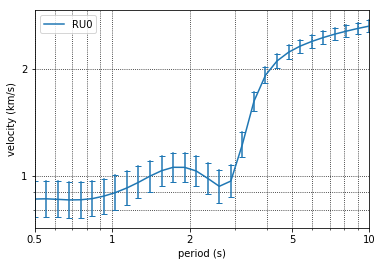

In [4]:
# -----------------
# compute the corresponding dispersion curves
# -----------------

os.system('rm -f dmtuto.surf96')
%run -i ../../srfpython/bin/m96 \
    --disp dmtuto.mod96 \
        -RU0 .1  2. 30 "log" \
        -save dmtuto.surf96
        
%run -i ../../srfpython/bin/s96 \
    --show dmtuto.surf96 \
        -inline        


In [5]:
# -----------------
# clean up
# -----------------
%run -i ../../srfpython/bin/HerrMet --clean

please keep only datapoints to invert in _HerrMet.target
use option --display to see the target data
_HerrMet.target
    Ulaw wave=R mode=0 type=U flag=T extrapmode=0 N=20


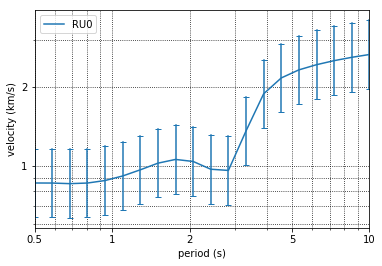

In [6]:
# -----------------
# set target data
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --target dmtuto.surf96 \
        -resamp .1 2. 20 "log" \
        -lunc .3 \
        -ot
%run -i ../../srfpython/bin/s96 \
    --show _HerrMet.target \
        -inline

# Two layers solution

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.600000         2.500000
       PR1         1.600000         2.500000
       RH0         2.200000         2.700000
       RH1         2.200000         2.700000

please customize _HerrMet.param, do not change line orders and metadata
use option --display to see the depth boundaries
parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


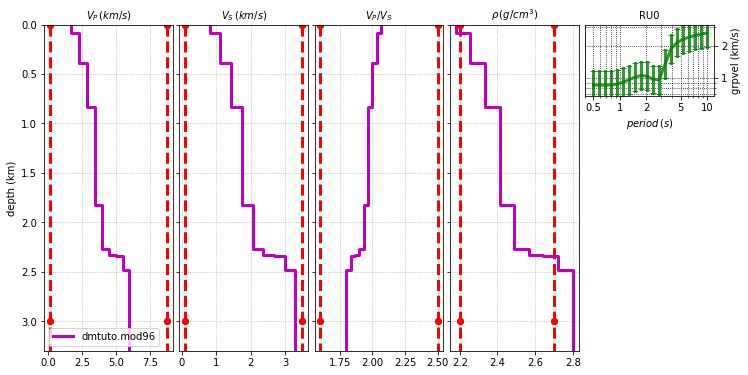

In [7]:
# -----------------
# set parameterization template
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --param 2 3. \
        -t mZVSPRRH \
        -growing \
        -op \
    --display \
        -m96 dmtuto.mod96 \
        -inline

parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


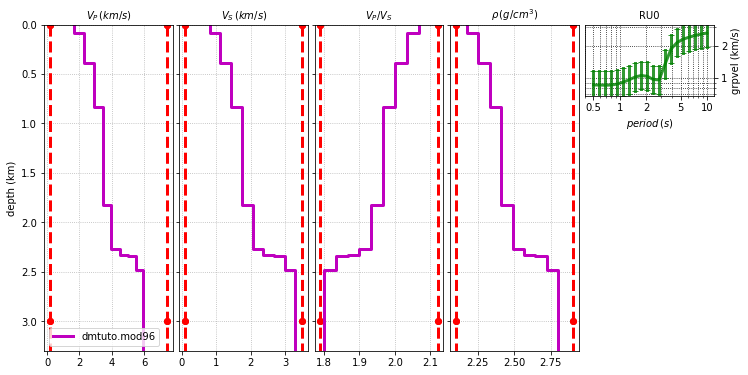

In [8]:
# -----------------
# customize parameterization manually
# -----------------
with open('_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 2
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -3.000000        -0.001000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       RH0         2.1              2.9
       RH1         2.1              2.9""")
%run -i ../../srfpython/bin/HerrMet \
    --display \
        -m96 dmtuto.mod96 \
        -inline

In [9]:
# -----------------
# trash previous run if any
# -----------------
os.system('trash _HerrMet.run')

18944

In [10]:
# -----------------
# run in append mode
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -w 4\
    -taskset "0-3" \
    -verbose off \
    --run append \
        -nchain 4 \
        -nkeep 200 
print "DONE"

parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR
chain    2  DONE kept  200/  766 fail   36 AK 0.26 MP 1.04 AS  24.04/s LI -5.120563
chain    1  DONE kept  200/  783 fail    6 AK 0.25 MP 0.91 AS  23.45/s LI -5.426393
chain    0  DONE kept  200/  822 fail   17 AK 0.24 MP 0.72 AS  24.23/s LI -4.331998
chain    3  DONE kept  200/  819 fail   27 AK 0.24 MP 0.74 AS  24.01/s LI -4.414051
DONE


top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.173299s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 804 models in 0.248922s 
Stacker Worker-0003 stacked    203 jobs in 0.164472s
Stacker Worker-0001 stacked    192 jobs in 0.193330s
Stacker Worker-0002 stacked    205 jobs in 0.174834s
Stacker Worker-0004 stacked    204 jobs in 0.166700s
parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


0

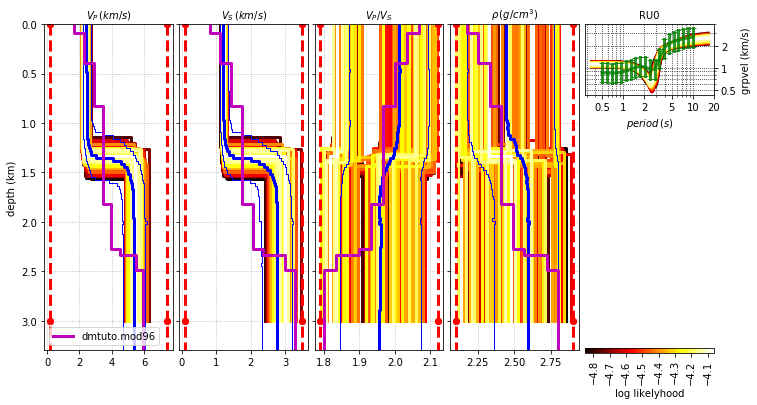

In [11]:
# -----------------
# display results
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -verbose off \
    --display \
        -top 0. 200 1 \
        -overdisp \
        -cmap hot \
        -pdf  \
        -m96 dmtuto.mod96 \
        -png \
        -inline
os.system('mv _HerrMet.png 2layers.png')

# 3 layers solution

parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


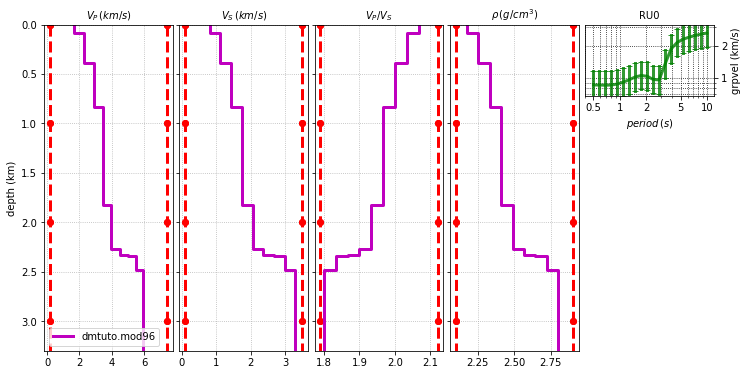

In [12]:
# -----------------
# customize parameterization manually
# -----------------
with open('_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 3
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -2.              -0.001000
       -Z3        -3.000000        -1.
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       PR0         1.79             2.12
       PR1         1.79             2.12
       PR2         1.79             2.12       
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9""")
%run -i ../../srfpython/bin/HerrMet \
    --display \
        -m96 dmtuto.mod96 \
        -inline

In [13]:
# -----------------
# trash previous run if any
# -----------------
os.system('trash _HerrMet.run')

0

In [14]:
# -----------------
# run in append mode
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -w 4\
    -taskset "0-3" \
    -verbose off \
    --run append \
        -nchain 4 \
        -nkeep 200 
print "DONE"

parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR
chain    3  DONE kept  200/  797 fail   39 AK 0.25 MP 0.86 AS  21.43/s LI -15.001224
chain    0  DONE kept  200/  848 fail   79 AK 0.23 MP 0.60 AS  22.52/s LI -2.704027
chain    1  DONE kept  200/  857 fail   67 AK 0.23 MP 0.52 AS  22.33/s LI -1.718679
chain    2  DONE kept  200/  889 fail   42 AK 0.22 MP 0.41 AS  22.42/s LI -3.937092
DONE


top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.155779s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 804 models in 0.235847s 
Stacker Worker-0004 stacked    197 jobs in 0.230130s
Stacker Worker-0001 stacked    211 jobs in 0.242466s
Stacker Worker-0002 stacked    196 jobs in 0.241645s
Stacker Worker-0003 stacked    200 jobs in 0.232235s
parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


0

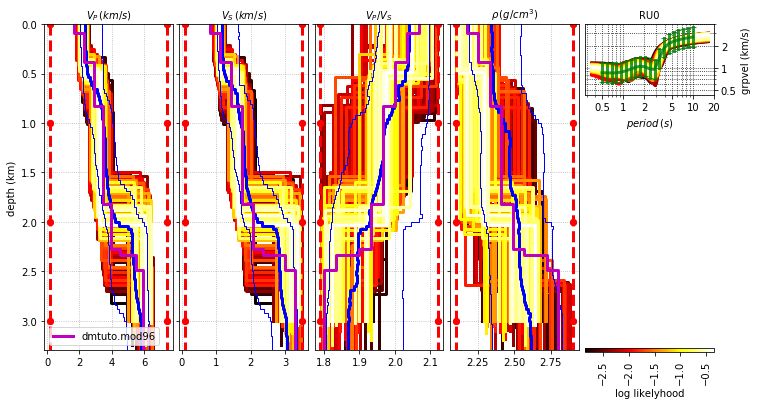

In [15]:
# -----------------
# display results
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -verbose off \
    --display \
        -top 0. 200 1 \
        -overdisp \
        -cmap hot \
        -pdf  \
        -m96 dmtuto.mod96 \
        -png \
        -inline
os.system('mv _HerrMet.png 3layers.png')

# 4 layers solution

#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -1.000000        -0.001000
       -Z2        -2.000000        -1.000000
       -Z3        -3.000000        -2.000000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       VS3         0.100000         3.500000
       PR0         1.600000         2.500000
       PR1         1.600000         2.500000
       PR2         1.600000         2.500000
       PR3         1.600000         2.500000
       RH0         2.200000         2.700000
       RH1         2.200000         2.700000
       RH2         2.200000         2.700000
       RH3         2.200000         2.700000

please customize _HerrMet.param, do not change line orders 

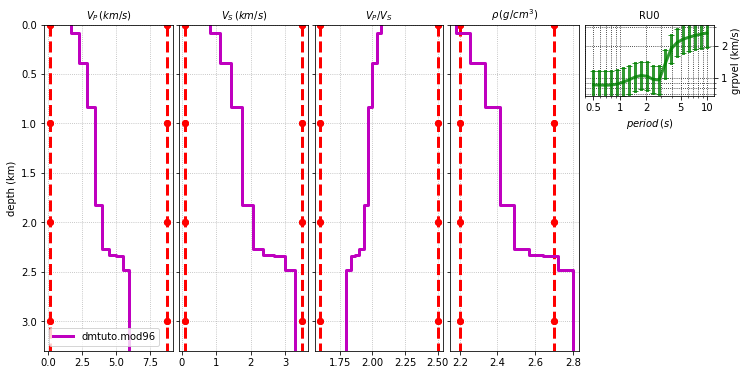

In [16]:
# -----------------
# set parameterization template
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    --param 4 3. \
        -t mZVSPRRH \
        -growing \
        -op \
    --display \
        -m96 dmtuto.mod96 \
        -inline

parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


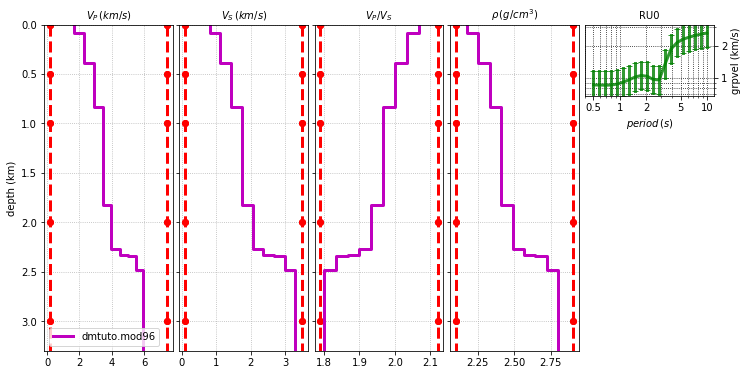

In [17]:
# -----------------
# customize parameterization manually
# -----------------
with open('_HerrMet.param', "w") as fid:
    fid.write("""
#met DRHMIN = 0.0
#met DPRMAX = 0.0
#met DVPMIN = 0.0
#met DRHMAX = 5.0
#met DVPMAX = 5.0
#met DVSMAX = 5.0
#met DPRMIN = -5.0
#met PRIORTYPE = 'DVPDVSDRHDPR'
#met NLAYER = 4
#met TYPE = 'mZVSPRRH'
#met DVSMIN = 0.0
#fld KEY VINF VSUP
#unt - - -
#fmt %5s %16f %16f
       -Z1        -1.000000        -0.001000
       -Z2        -2.000000        -0.500000
       -Z3        -3.000000        -1.000000
       VS0         0.100000         3.500000
       VS1         0.100000         3.500000
       VS2         0.100000         3.500000
       VS3         0.100000         3.500000
       PR0         1.79             2.12       
       PR1         1.79             2.12       
       PR2         1.79             2.12       
       PR3         1.79             2.12          
       RH0         2.1              2.9
       RH1         2.1              2.9
       RH2         2.1              2.9
       RH3         2.1              2.9""")
%run -i ../../srfpython/bin/HerrMet \
    --display \
        -m96 dmtuto.mod96 \
        -inline

In [18]:
# -----------------
# trash previous run if any
# -----------------
os.system('trash _HerrMet.run')

0

In [19]:
# -----------------
# run in append mode
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -w 4\
    -taskset "0-3" \
    -verbose off \
    --run append \
        -nchain 4 \
        -nkeep 400 
print "DONE"

parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR
chain    0  DONE kept  400/ 1684 fail  140 AK 0.24 MP 0.36 AS  25.37/s LI -3.903290
chain    2  DONE kept  400/ 1643 fail   90 AK 0.24 MP 0.49 AS  24.69/s LI -3.459109
chain    1  DONE kept  400/ 1657 fail   62 AK 0.24 MP 0.49 AS  24.61/s LI -3.391666
chain    3  DONE kept  400/ 1685 fail   83 AK 0.24 MP 0.38 AS  24.82/s LI -1.466534
DONE


top : llkmin 0.000000, limit 200, step 1 retrieved 200 models in 0.276986s 
pdf : llkmin 0.000000, limit 0, step 1 retrieved 1604 models in 0.653378s 
Stacker Worker-0001 stacked    421 jobs in 0.651290s
Stacker Worker-0003 stacked    355 jobs in 0.653196s
Stacker Worker-0002 stacked    378 jobs in 0.668495s
Stacker Worker-0004 stacked    450 jobs in 0.616179s
parameter type :  Parameterizer_mZVSPRRH
prior type     :  LogRhoM_DVPDVSDRHDPR


0

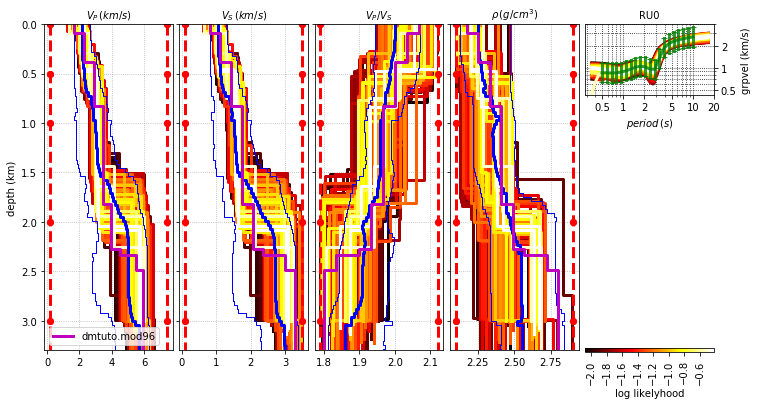

In [20]:
# -----------------
# display results
# -----------------
%run -i ../../srfpython/bin/HerrMet \
    -verbose off \
    --display \
        -top 0. 200 1 \
        -overdisp \
        -cmap hot \
        -pdf  \
        -m96 dmtuto.mod96 \
        -png \
        -inline
os.system('mv _HerrMet.png 4layers.png')